In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import string
import re
import xgboost
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud ,STOPWORDS

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.wsd import lesk
from nltk.stem import PorterStemmer
from keras import layers, models, optimizers

Using TensorFlow backend.


In [4]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble

In [5]:
import nltk
# nltk.download()

In [6]:
bank=pd.read_excel('BankReviews.xlsx')

In [7]:
bank.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [8]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [9]:
len(bank['Reviews'])

505

In [10]:
TextBlob(bank['Reviews'][0]).detect_language()

'en'

### Basic Exploratory Analysis

In [11]:
df=bank

In [12]:
eng_stopwords = set(stopwords.words("english"))

In [13]:
df['Reviews'] = df['Reviews'].astype(str)
df['count_sent']=df["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["Reviews"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["Reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df['Reviews'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 

In [14]:
df.head()

,Date,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,...,alphabetetics,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,...,15,0,0,0,"{'through': 1, 'you!': 1, 'Each': 1, 'us': 1, ...",0,0,0,0,0
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,...,21,0,0,0,"{'much': 1, 'very': 1, 'us': 1, 'product': 1, ...",0,0,0,0,0
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,...,73,0,0,1,"{'needs.': 1, 'use': 1, 'pulled': 1, 'a': 3, '...",0,0,0,0,0
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,...,101,0,0,1,"{'needs.': 1, 'on': 1, 'from': 3, 'they': 1, '...",0,0,0,0,0
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,...,53,0,0,1,"{'His': 1, 'time': 1, 'about': 1, 'how': 1, 'v...",0,0,0,0,0


### Split the data into Train & Test

In [15]:
# define X and y
X = bank.Reviews
y = bank.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404,)
(101,)
(404,)
(101,)


### Tokenization

In [16]:
def tokenization(text):
    text=word_tokenize(text)
    return(text)

In [17]:
token_X_train = X_train.apply(lambda x: tokenization(x))
token_X_test = X_test.apply(lambda x: tokenization(x))

### POS Tagging

In [18]:
def pos_tagging(text):
    text = nltk.pos_tag(text)
    return(text)

In [19]:
pos_tag_X_train = token_X_train.apply(lambda x: pos_tagging(x))
pos_tag_X_test = token_X_test.apply(lambda x: pos_tagging(x))

### Disabiguation

In [20]:
# Disambiguation
syn=lesk(X_train, 'refinance', 'v')
print(syn)
print(syn.name())
print(syn.definition())   # meaning of refinance
print(syn.examples())

Synset('refinance.v.01')
refinance.v.01
renew the financing of
[]


In [21]:
print(syn.hypernyms())       # Opposite word of refinance
print(syn.hyponyms())

[Synset('finance.v.01')]
[]


In [22]:
syn.lemmas()                  # Synonyms of refinance

[Lemma('refinance.v.01.refinance')]

### Clean up of non- textual data (white space, numbers, symbols)

In [23]:
import string
def clean_text(text):
    text = text.lower()                                       # Convert text to lower case
    text = text.strip()
    text = re.sub(r'  ', ' ', text)                           #Replacing double space with single space
    text = text.replace('/','')                               #Replacing the / with none
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    
    return(text)

In [24]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

### Stop word removal

In [25]:
stop = set(nltk.corpus.stopwords.words('english'))
def stop_word_removal(text):
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    text = text.apply(lambda x: str(TextBlob(x).correct()))                      # Correct spelling corrections
    return(text)

In [26]:
X_train=stop_word_removal(X_train)
X_test=stop_word_removal(X_test)

### Lemmatization

In [27]:
def lemmatization(text):
    
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))    # Lemmatization
    text = text.apply(lambda x: " ".join(word for word, pos in nltk.pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [28]:
X_train=lemmatization(X_train)
X_test=lemmatization(X_test)

### Vectorization for Train only

In [29]:
#Train
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
X_train_counts = count_vect.fit_transform(X_train)

In [30]:
X_train_counts

<404x380 sparse matrix of type '<class 'numpy.int64'>'
	with 5702 stored elements in Compressed Sparse Row format>

In [31]:
X_train_dtm = X_train_counts.toarray()
X_train_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Examining the tokens and their counts

In [32]:
# store token names
X_train_tokens = count_vect.get_feature_names()

In [33]:
# first 50 tokens
print(X_train_tokens[:50])

['aaron', 'able', 'absolutely', 'accept', 'achieve', 'across', 'actual', 'adam', 'additional', 'agreed', 'all', 'almost', 'along', 'already', 'also', 'always', 'amazing', 'american', 'another', 'answer', 'answered', 'answering', 'appraisal', 'appraise', 'appreciated', 'approved', 'around', 'ask', 'asked', 'asking', 'aspect', 'attentive', 'available', 'away', 'awesome', 'back', 'bad', 'based', 'became', 'beginning', 'beneficial', 'best', 'better', 'beyond', 'big', 'buy', 'buying', 'ca', 'call', 'called']


In [34]:
# last 50 tokens
print(X_train_tokens[-50:])

['that', 'thorough', 'thou', 'though', 'thought', 'thousand', 'three', 'throughout', 'timely', 'together', 'told', 'took', 'top', 'tormented', 'total', 'tree', 'tried', 'true', 'truly', 'trusted', 'trying', 'twice', 'two', 'u', 'understood', 'unless', 'unlike', 'unpleasant', 'updated', 'upon', 'use', 'used', 'using', 'various', 'via', 'want', 'wanted', 'well', 'went', 'whole', 'willing', 'within', 'without', 'wonderful', 'worked', 'working', 'would', 'wrong', 'wyndham', 'yet']


In [35]:
# count how many times EACH token appears across ALL messages in X_train_dtm
X_train_counts = np.sum(X_train_dtm, axis=0)
X_train_counts

array([  7,  38,  11,   6,   5,  13,   7,  24,  12,   6,  15,  13,  14,
        12,  37,  70,  19,   7,  25,  23,  23,   8,  11,   6,   9,   6,
        12,  14,  23,   9,   6,   5,  21,   7,   9,  36,  12,   8,   6,
        22,  16,  82,  23,  19,   7,  21,   6,   6,  23,  45,   7,   9,
        26,  21,   5,   8,  11,   9,   7,  12,  46,  54,  36,  21,  10,
         6,   7,  10,  14,  10,  16,   8,   5,  20,   6,  57,   6,  14,
         7,  16,   9,  12,  25,  11,   9,  23,   8,  12,  38,  13,  10,
         7,   7,  48,   6,  20,  16,   5,   6,   6,  14,  12,  37,  46,
        27,  53,   8,  20,   7,   9,   9,   9,  12,  10,   7,   5,  15,
        36,   8,  10,  16,  18,   7,  20,   6,   9,   7,  22,  11,  10,
         5,   6,  65,  11,  33,   7,  15,  12,   5,  13,   9,  31,   5,
         7,   6,   8,  14,  57,  22,  27,   5,  32,  39,  37,  48, 117,
        18,   5,   5,   8,   5,   5,  30,  33,   6,  29,  29,  12,   9,
        54,   8,   5,   6,  13,  15,   5,   7,   6,   7,  16,   

In [36]:
# create a DataFrame of tokens with their counts
token_count=pd.DataFrame({'token':X_train_tokens, 'count':X_train_counts})
token_count.sort_values(by=['count'],ascending=False,inplace=True)
token_count

,token,count
376,would,182
353,u,141
155,great,117
282,recommend,113
209,made,86
41,best,82
15,always,70
374,worked,66
132,first,65
263,professional,59


### Simple statistics

Counting Words Appearing in a Text (a frequency distribution). 


In [37]:
Top20=token_count[:20]

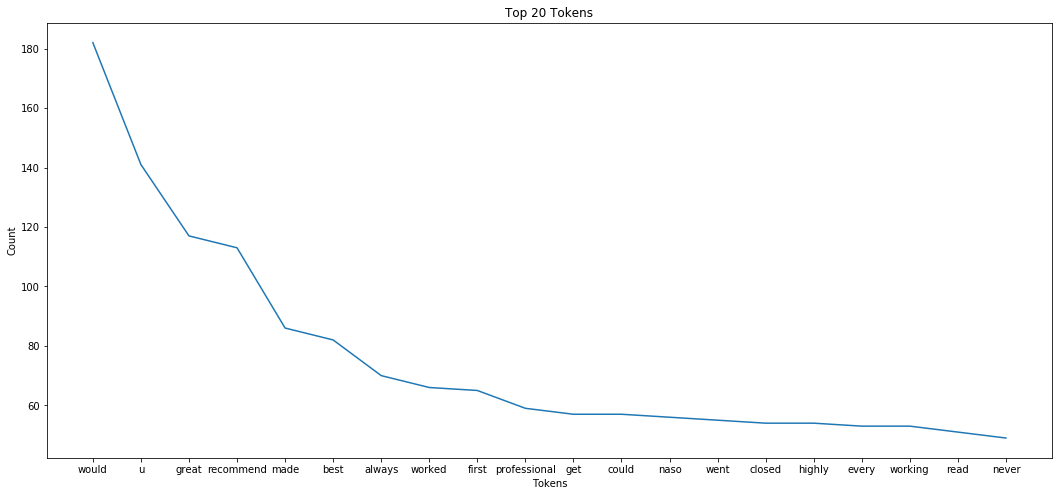

In [38]:
#Top20.plot('token','count')
plt.figure(figsize=(18,8))
plt.plot('token','count',data=Top20)
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Top 20 Tokens')

plt.show()

### Word Cloud

In [39]:
frequency_words_wo_stop= {}
for data in bank['Reviews']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [40]:
frequency_words_wo_stop

{'great': 139,
 'job': 25,
 ',': 1135,
 'wyndham': 16,
 'capital': 12,
 '!': 222,
 'person': 17,
 'professional': 70,
 'helped': 35,
 'us': 207,
 'move': 12,
 'refinance': 70,
 'process': 253,
 'smoothly': 15,
 '.': 1976,
 'thank': 50,
 'matthew': 3,
 'richardson': 1,
 'helpful': 56,
 'find': 19,
 'correct': 1,
 'product': 10,
 'mortgage': 147,
 'much': 38,
 'excellent': 30,
 'service': 99,
 'past': 13,
 'experience': 110,
 'would': 246,
 'without': 29,
 'question': 7,
 'use': 48,
 'needed': 29,
 '!!': 24,
 'went': 70,
 'beyond': 25,
 'extra': 19,
 'mile': 8,
 'right': 28,
 'wrong': 7,
 'encountered': 7,
 'servicer': 3,
 'dealing': 14,
 'previous': 13,
 'loan': 313,
 'pulled': 4,
 'together': 8,
 'found': 16,
 'viable': 3,
 'option': 8,
 'ultimately': 5,
 'saved': 7,
 'money': 22,
 'highly': 65,
 'recommend': 156,
 'brad': 7,
 'thomka': 3,
 'team': 113,
 'needs': 27,
 'sincerest': 2,
 'thanks': 61,
 'ed': 2,
 '&': 30,
 'lind': 1,
 'beginning': 32,
 'started': 17,
 'stressful': 24,
 'ti

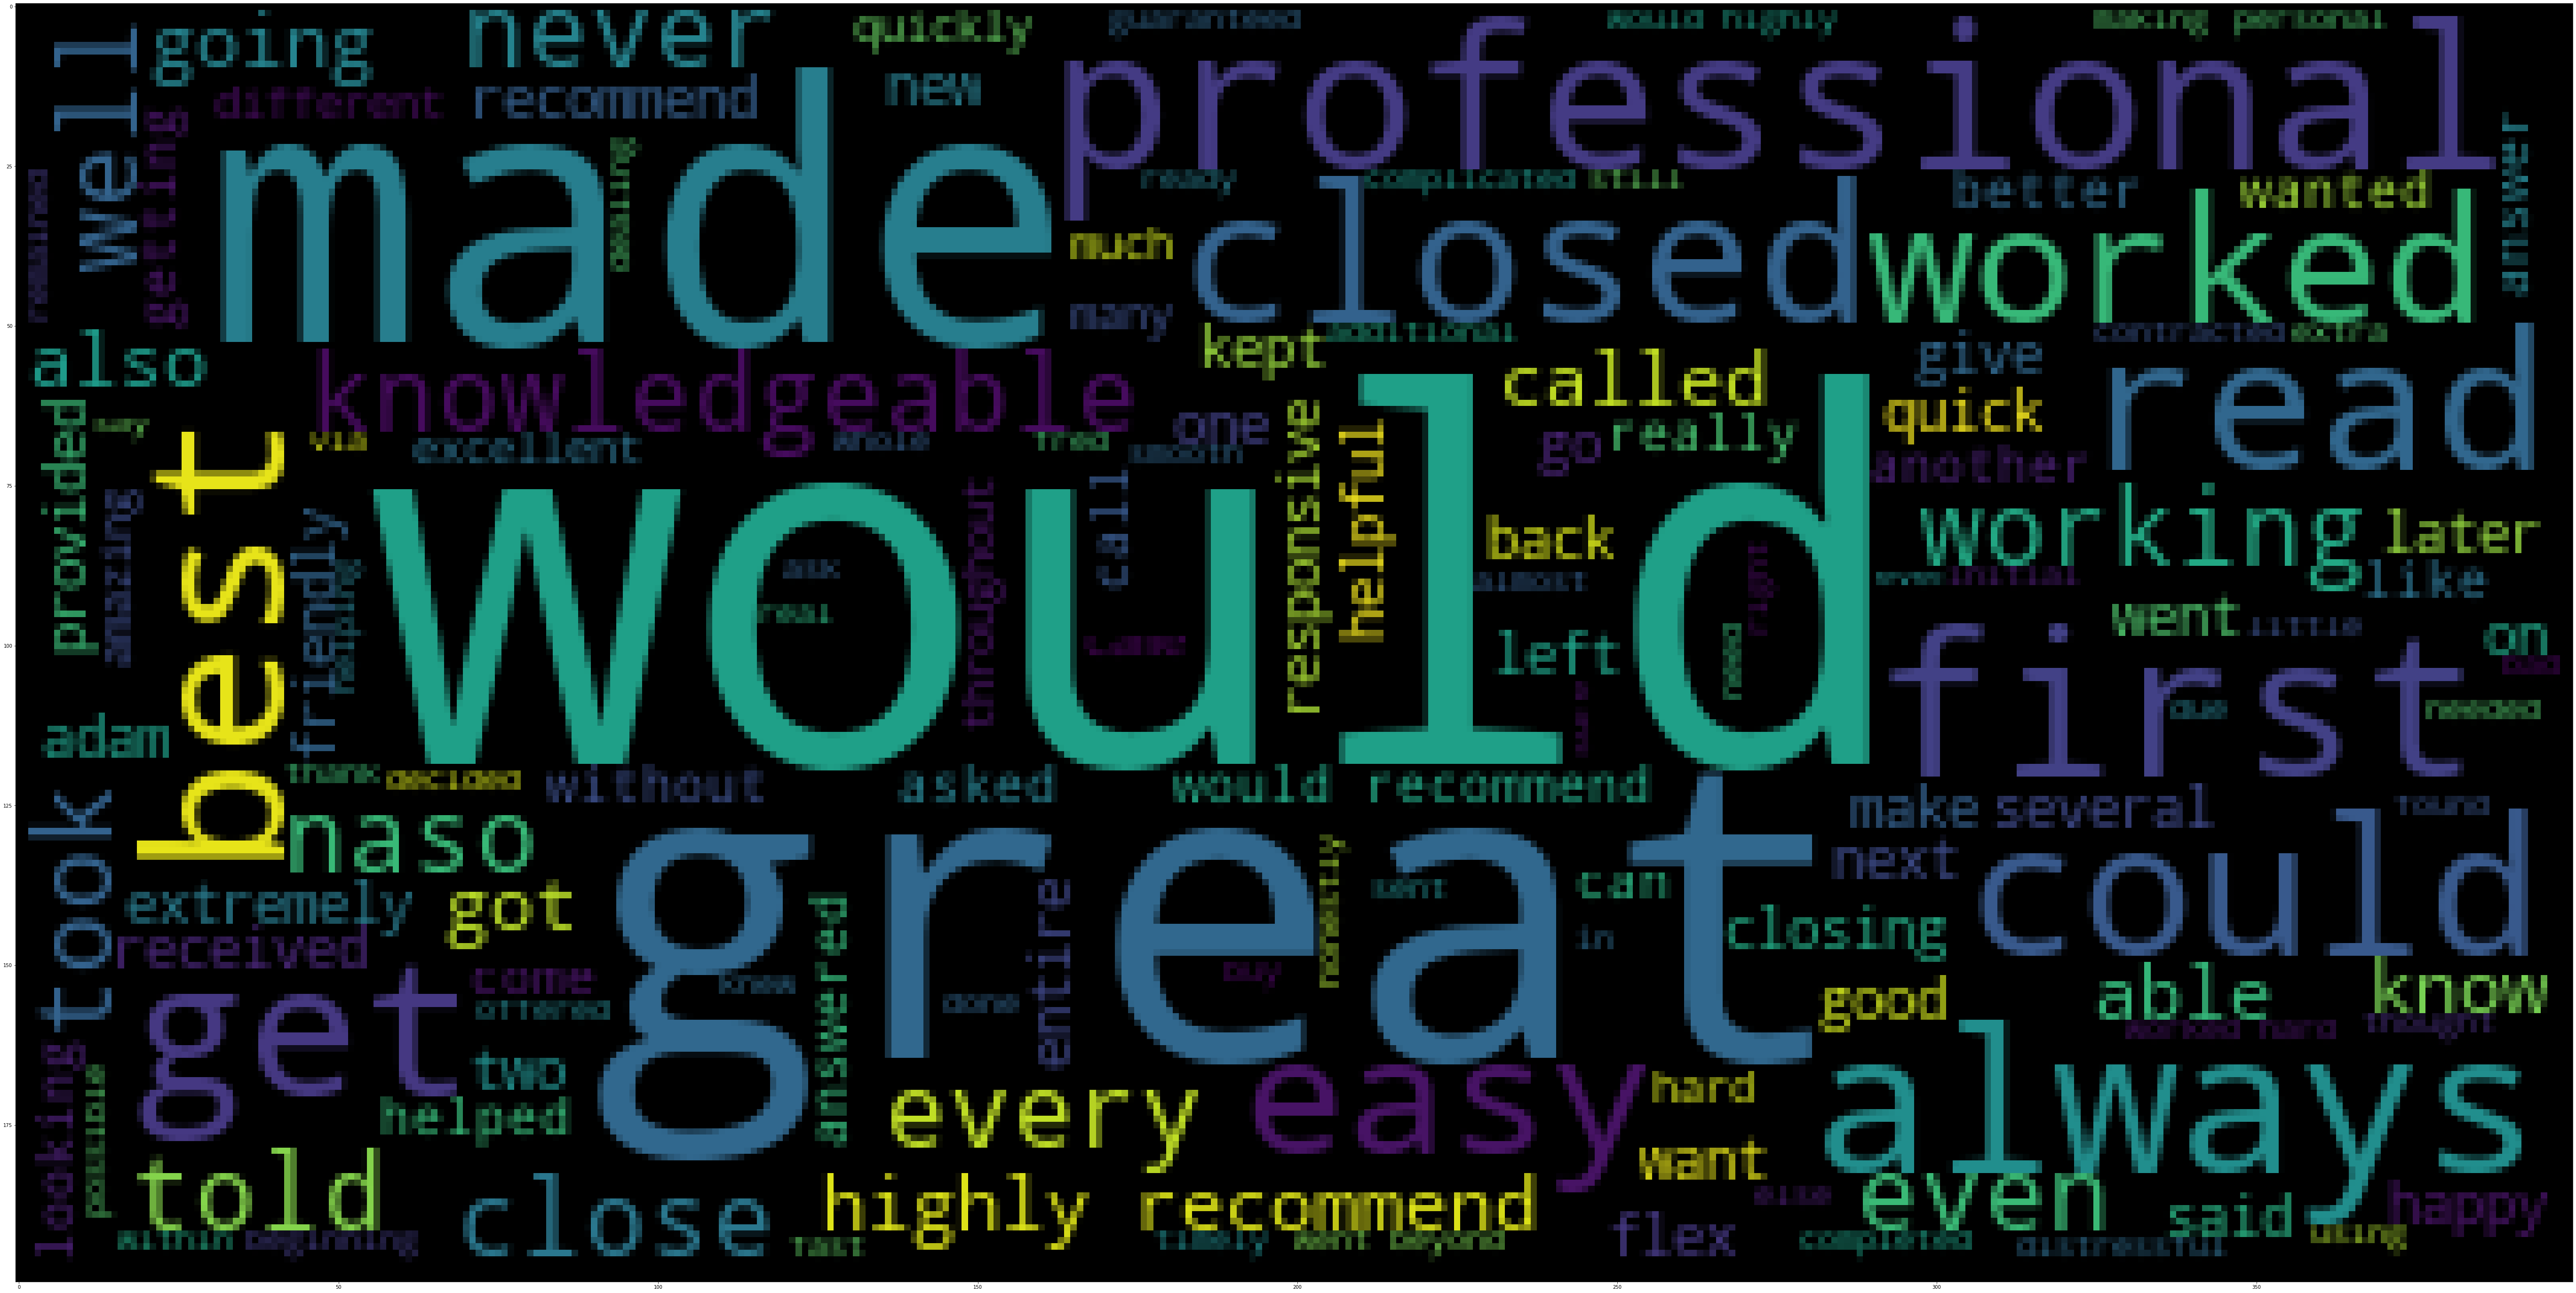

In [41]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

### Classify reviews to positive, negative and neutral

In [42]:
# We use textblob utility to calculate polarity
def get_sentiment(text):
    # create TextBlob object of passed text 
    analysis = TextBlob(text) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'

In [43]:
text = X_train
sentiment = X_train.apply(lambda x: get_sentiment(x))
Table = pd.concat([text,sentiment],axis=1)
column_names = Table.columns.values
column_names[1] = 'Sentiment'
Table.columns = column_names
Table

,Reviews,Sentiment
442,got best matched even better got,positive
42,started nick going ok fro earlier must made po...,positive
58,easy going extra overcoming truthful dependabl...,positive
481,great great easily best worked,positive
78,first steve knew understood perfectly able u a...,positive
423,expert well versed va financial best worked ac...,positive
160,far best ever worked dealing complicated two d...,positive
185,first inquired bent ago told wanted hold buy l...,positive
101,worst lending provided incorrect led spend app...,negative
268,really enjoyed provided stephanie dreary frien...,positive


In [44]:
# picking positive reviews
positive = Table[Table.Sentiment == 'positive']
# percentage of positive reviews 
print("Positive tweets percentage: {} %".format(100*len(positive)/len(Table.Reviews))) 


# picking negative reviews
negative = Table[Table.Sentiment == 'negative']
# percentage of negative reviews 
print("Negative tweets percentage: {} %".format(100*len(negative)/len(Table.Reviews))) 

# percentage of neutral reviews
print("Neutral tweets percentage: {} %".format(100*(len(Table.Reviews)-len(negative)-len(positive))/len(Table.Reviews))) 

Positive tweets percentage: 87.12871287128714 %
Negative tweets percentage: 8.910891089108912 %
Neutral tweets percentage: 3.9603960396039604 %


In [45]:
# Top 5 positive reviews
positive.head(5)['Reviews'].tolist()

['got best matched even better got',
 'started nick going ok fro earlier must made possible would understood never heard called nick several even called remained want due',
 'easy going extra overcoming truthful dependable professional',
 'great great easily best worked',
 'first steve knew understood perfectly able u achieve given realistic beginning steve kept touch u throughout gave u accurate u along']

In [46]:
# Top 5 negative reviews
negative.head(5)['Reviews'].tolist()

['worst lending provided incorrect led spend appraisal quite twice much putting close new oh yes one made yet yet explain wont say hello',
 'responsive worked hard u approved on really made u like',
 'miserable screwed imaginable never accepted recommend hothouse much purchasing new',
 'first capitol kenneth you frustrated him arrogantevery talked would always stylet call back hear happened probably want extremely badge raise took probably monthbut took little get said lost also motorcycle supposed get ill call back his called back next read',
 'taking soon found stopped would return call finally got hold short little asked detail went different']

### K-Means Cluster Analysis

In [47]:
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [48]:
tf_idf_vectorizor = TfidfVectorizer(max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(X_train)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [49]:
class Kmeans:
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
    
    def initialise_centroids(self, data):
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        return self.centroids
    
    def assign_clusters(self, data):
       
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        return  self.cluster_labels
    
    def update_centroids(self, data):
       
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self, data):
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
      
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self    

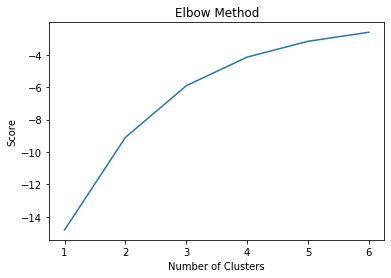

In [50]:
number_clusters = range(1, 7)
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


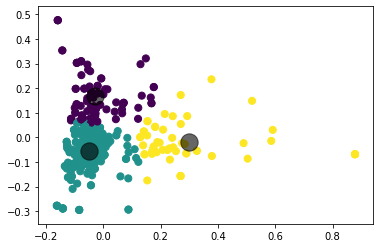

In [51]:
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [52]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [53]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
df1,df2,df3 = get_top_features_cluster(tf_idf_array, prediction, 15)
df1

,features,score
0,would,0.040542
1,get,0.028075
2,good,0.025767
3,professional,0.024745
4,went,0.023047
5,every,0.022768
6,able,0.022634
7,got,0.022401
8,always,0.022313
9,closed,0.022286


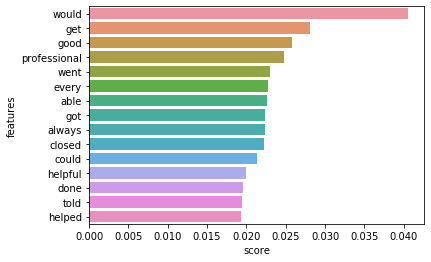

In [54]:
# cluster1 top 15 words
sns.barplot(x='score',y="features", data=df1)
plt.show()

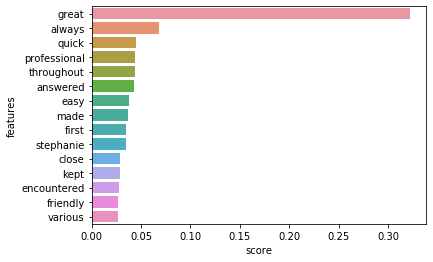

In [55]:
# cluster2 top 15 words 
sns.barplot(x='score',y="features", data=df2)
plt.show()

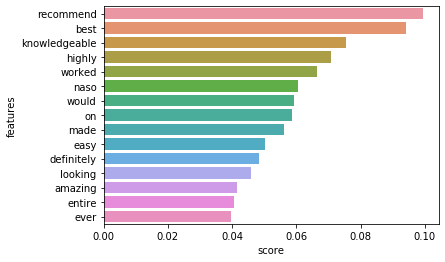

In [56]:
# cluster3 top 15 words
sns.barplot(x='score',y="features", data=df3)
plt.show()

### Vectorization (count, tfidf) for both train & test (word level tf-idf)

In [57]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)


In [58]:
dtm2=pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

In [59]:
dtm2.head(10)

,aaron,able,absolutely,accept,achieve,across,actual,adam,additional,agreed,...,willing,within,without,wonderful,worked,working,would,wrong,wyndham,yet
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.131871,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.355260,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.172342,0.0,0.0,0.260478,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
5,0.194955,0.000000,0.0,0.0,0.000000,0.175734,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.112632,0.0,0.000000,0.0,0.0,0.000000
6,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.172073,0.0,0.000000,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.157256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.570871
9,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


### N-gram generators (n-gram level tf-idf)

In [60]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', ngram_range=(1, 2), max_features=800)
tfidf_vect_ngram.fit(bank['Reviews'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

### character level tf-idf

In [61]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern='\w{1,}', ngram_range=(1,2), max_features=800)
tfidf_vect_ngram_chars.fit(bank['Reviews'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

### Topic Modeling

In [62]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [63]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['due great real later make stayed pay also finally overall',
 'super attentive explaining smooth make poor well excellent looking many',
 'new purchasing much never easier steve recommend say followed completed',
 'every helped quick easy u friendly efficient best great fantastic',
 'poor expired contracted sign required minute unless actual communicated appraise',
 'seemed actual paid monthly twice necessary explaining high provided new',
 'no could told send id rotary purchased four agreed accept',
 'fred stayed put awesome quick sure knowledgeable closed highly made',
 'would closed naso able beginning know even closing made want',
 'fine good overall required received initially sign mistake trusted asking',
 'offer fred making make in kept went including wrong sure',
 'honest responsive good working ask flex better awesome hard worked',
 'previous contracted professional lender naso best military can complicated express',
 'u always on went well timely worked great make would',
 '

### Create user defined function for train the models

In [64]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

## Building different models with different vectors

### 1) Naive Bayes

In [65]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB for L1, Count Vectors: ", accuracy_L1)



# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print("NB for L1, WordLevel TF-IDF: ", accuracy_L1)



# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("NB for L1, N-Gram Vectors: ", accuracy_L1)



# Naive Bayes on Character Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("NB for L1, CharLevel Vectors: ", accuracy_L1)

NB for L1, Count Vectors:  0.8910891089108911
NB for L1, WordLevel TF-IDF:  0.9306930693069307
NB for L1, N-Gram Vectors:  0.8217821782178217
NB for L1, CharLevel Vectors:  0.8118811881188119


### 2) Logistic regression

In [66]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(linear_model.LogisticRegression(solver='lbfgs'), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(linear_model.LogisticRegression(solver='lbfgs'), xtrain_count, y_train, xtest_count, y_test)
print("LR for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(linear_model.LogisticRegression(solver='lbfgs'), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR for L1, N-Gram Vectors: ", accuracy_L1)



# Logistic Regression on Character Level TF IDF Vectors
accuracy_L1 = train_model(linear_model.LogisticRegression(solver='lbfgs'), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR for L1, Count Vectors:  0.8811881188118812
LR for L1, WordLevel TF-IDF:  0.9306930693069307
LR for L1, N-Gram Vectors:  0.900990099009901
LR for L1, CharLevel Vectors:  0.8118811881188119


###  3) SVM

In [69]:
import warnings
warnings.filterwarnings("ignore")    # Ignore all warnings

#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_count, y_train, xtest_count, y_test)
print("SVC for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("SVC for L1, N-Gram Vectors: ", accuracy_L1)



# Linear SVC on Character Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("SVC for L1, CharLevel Vectors: ", accuracy_L1)

SVC for L1, Count Vectors:  0.9504950495049505
SVC for L1, WordLevel TF-IDF:  0.9306930693069307
SVC for L1, N-Gram Vectors:  0.9504950495049505
SVC for L1, CharLevel Vectors:  0.9306930693069307


### 4) Bagging

In [70]:
# Random Forest Classifier
# Random Forest Classifier on Count Vectors and TF-IDF
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Bagging for L1, Count Vectors: ", accuracy_L1)



# Random Forest Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("Bagging for L1, WordLevel TF-IDF: ", accuracy_L1)



# Random Forest Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("Bagging for L1, N-Gram Vectors: ", accuracy_L1)



# Random Forest Classifier on Character Level TF IDF Vectors
accuracy_L1 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("Bagging for L1, CharLevel Vectors: ", accuracy_L1)

Bagging for L1, Count Vectors:  0.900990099009901
Bagging for L1, WordLevel TF-IDF:  0.9207920792079208
Bagging for L1, N-Gram Vectors:  0.8910891089108911
Bagging for L1, CharLevel Vectors:  0.8811881188118812


### 5) Boosting

In [71]:
# xgboost
# XGB Classifier on Count Vectors and TF-IDF
accuracy_L1 = train_model(xgboost.XGBClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Boosting for L1, Count Vectors: ", accuracy_L1)



# XGB Classifier on Word Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("Boosting for L1, WordLevel TF-IDF: ", accuracy_L1)



# XGB Classifier on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("Boosting for L1, N-Gram Vectors: ", accuracy_L1)



# XGB Classifier on Character Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("Boosting for L1, CharLevel Vectors: ", accuracy_L1)

Boosting for L1, Count Vectors:  0.9207920792079208
Boosting for L1, WordLevel TF-IDF:  0.9108910891089109
Boosting for L1, N-Gram Vectors:  0.9207920792079208
Boosting for L1, CharLevel Vectors:  0.9306930693069307


### 6) Shallow Neural Networks

In [164]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return(classifier) 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])

In [165]:
# neural networks
# NN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, is_neural_net=True)
print("NN for L1, N-Gram Vectors: ", accuracy_L1)



# NN on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("NN for L1, CharLevel Vectors: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 1s 1ms/step - loss: 0.1442
NN for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 0s 178us/step - loss: -1.4674
NN for L1, CharLevel Vectors:  0.0


### 7) Deep Neural Networks

Deep Neural Networks are more complex neural networks in which the hidden layers performs much more complex operations than simple sigmoid or relu activations. Different types of deep learning models can be applied in text classification problems.

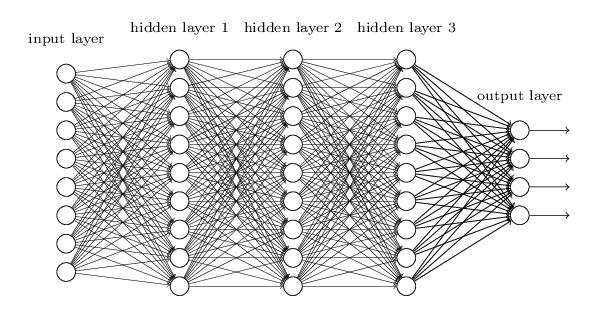

#### a) Convolutional Neural Network (CNN)

In Convolutional neural networks, convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.

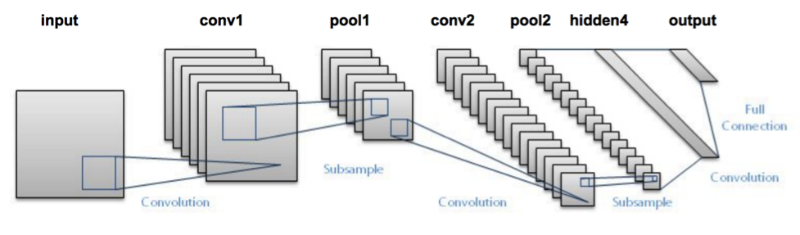

In [203]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((800, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()

In [206]:
# convolutional neural networks
# CNN on Count Vectors and TF-IDF
accuracy_L1 = train_model(xgboost.XGBClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("CNN for L1, Count Vectors: ", accuracy_L1)



# CNN on Word Level TF IDF Vectors
accuracy_L1 = train_model(xgboost.XGBClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("CNN for L1, WordLevel TF-IDF: ", accuracy_L1)



# convolutional neural networks
# CNN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test,is_neural_net=True)
print("CNN for L1, N-Gram Vectors: ", accuracy_L1)



# CNN on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("CNN for L1, CharLevel Vectors: ", accuracy_L1)

CNN for L1, Count Vectors:  0.9207920792079208
CNN for L1, WordLevel TF-IDF:  0.9108910891089109
Epoch 1/1
404/404 [==============================] - 4s 9ms/step - loss: -33.4434
CNN for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 4s 10ms/step - loss: -50.4597
CNN for L1, CharLevel Vectors:  0.0


#### b) Recurrent Neural Network – LSTM

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

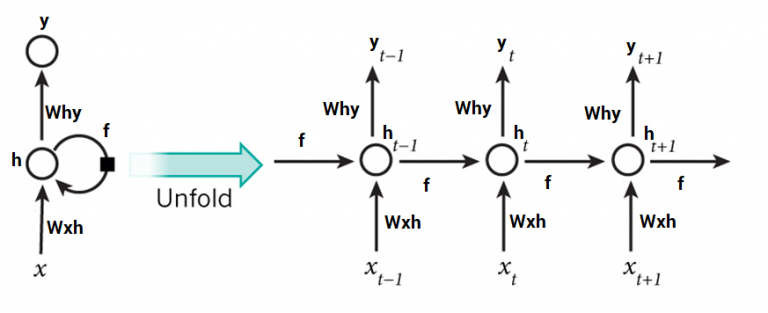

In [210]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((380, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()

In [211]:
# recurrent neural networks
# RNN-LSTM on Count Vectors and TF-IDF
accuracy_L1 = train_model(classifier, X_train_tfidf, y_train, X_test_tfidf, y_test,is_neural_net=True)
print("RNN-LSTM for L1, Count Vectors: ", accuracy_L1)



# RNN-LSTM on Word Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_count, y_train, xtest_count, y_test,is_neural_net=True)
print("RNN-LSTM for L1, WordLevel TF-IDF: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 11s 27ms/step - loss: -2.5381
RNN-LSTM for L1, Count Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 7s 16ms/step - loss: -23.8016
RNN-LSTM for L1, WordLevel TF-IDF:  0.0


In [212]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((800, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()

In [213]:
# RNN-LSTM on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test,is_neural_net=True)
print("RNN-LSTM for L1, N-Gram Vectors: ", accuracy_L1)



# RNN-LSTM on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("RNN-LSTM for L1, CharLevel Vectors: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 18s 46ms/step - loss: -2.7305
RNN-LSTM for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 15s 38ms/step - loss: -23.5718
RNN-LSTM for L1, CharLevel Vectors:  0.0


#### c) Recurrent Neural Network – GRU

Gated Recurrent Units are another form of recurrent neural networks. Lets add a layer of GRU instead of LSTM in our network

In [221]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((380, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()

In [222]:
# recurrent neural networks
# RNN-GRU on Count Vectors and TF-IDF
accuracy_L1 = train_model(classifier, X_train_tfidf, y_train, X_test_tfidf, y_test,is_neural_net=True)
print("RNN-GRU for L1, Count Vectors: ", accuracy_L1)



# RNN-GRU on Word Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_count, y_train, xtest_count, y_test,is_neural_net=True)
print("RNN-GRU for L1, WordLevel TF-IDF: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 8s 21ms/step - loss: -2.1257
RNN-GRU for L1, Count Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 6s 15ms/step - loss: -30.8672
RNN-GRU for L1, WordLevel TF-IDF:  0.0


In [219]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((800, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()

In [220]:
# RNN-GRU on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test,is_neural_net=True)
print("RNN-GRU for L1, N-Gram Vectors: ", accuracy_L1)



# RNN-GRU on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("RNN-GRU for L1, CharLevel Vectors: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 15s 37ms/step - loss: -1.9656
RNN-GRU for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 14s 34ms/step - loss: -28.6557
RNN-GRU for L1, CharLevel Vectors:  0.0


#### d) Bidirectional RNN

RNN layers can be wrapped in Bidirectional layers as well. Lets wrap our GRU layer in bidirectional layer.

In [230]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((380, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()

In [231]:
# recurrent neural networks
# Bidirectional RNN on Count Vectors and TF-IDF
accuracy_L1 = train_model(classifier, X_train_tfidf, y_train, X_test_tfidf, y_test,is_neural_net=True)
print("Bidirectional RNN for L1, Count Vectors: ", accuracy_L1)



# Bidirectional RNN on Word Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_count, y_train, xtest_count, y_test,is_neural_net=True)
print("Bidirectional RNN for L1, WordLevel TF-IDF: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 21s 52ms/step - loss: -4.2183
Bidirectional RNN for L1, Count Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 17s 43ms/step - loss: -41.7676
Bidirectional RNN for L1, WordLevel TF-IDF:  0.0


In [228]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((800, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()

In [229]:
# Bidirectional RNN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test,is_neural_net=True)
print("Bidirectional RNN for L1, N-Gram Vectors: ", accuracy_L1)



# Bidirectional RNN on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("Bidirectional RNN for L1, CharLevel Vectors: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 40s 98ms/step - loss: -3.5167
Bidirectional RNN for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 39s 96ms/step - loss: -40.8454
Bidirectional RNN for L1, CharLevel Vectors:  0.0


#### e) Recurrent Convolutional Neural Network (RCNN)

Once the essential architectures have been tried out, one can try different variants of these layers such as recurrent convolutional neural network. Another variants can be:

- Hierarichial Attention Networks

- Sequence to Sequence Models with Attention

- Bidirectional Recurrent Convolutional Neural Networks

- CNNs and RNNs with more number of layers

In [236]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((380, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()

In [237]:
# recurrent convonutional neural networks
# RCNN on Count Vectors and TF-IDF
accuracy_L1 = train_model(classifier, X_train_tfidf, y_train, X_test_tfidf, y_test,is_neural_net=True)
print("RCNN for L1, Count Vectors: ", accuracy_L1)



# RCNN on Word Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_count, y_train, xtest_count, y_test,is_neural_net=True)
print("RCNN for L1, WordLevel TF-IDF: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 5s 13ms/step - loss: -1.6187
RCNN for L1, Count Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 2s 5ms/step - loss: -11.4745 0s - loss: 
RCNN for L1, WordLevel TF-IDF:  0.0


In [238]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((800, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()

In [239]:
# RCNN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test,is_neural_net=True)
print("RCNN for L1, N-Gram Vectors: ", accuracy_L1)



# RCNN on Character Level TF IDF Vectors
accuracy_L1 = train_model(classifier, xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test,is_neural_net=True)
print("RCNN for L1, CharLevel Vectors: ", accuracy_L1)

Epoch 1/1
404/404 [==============================] - 8s 19ms/step - loss: -2.2498
RCNN for L1, N-Gram Vectors:  0.0
Epoch 1/1
404/404 [==============================] - 4s 9ms/step - loss: -12.9959
RCNN for L1, CharLevel Vectors:  0.0


### Predicting star ratings using reviews

In [240]:
texts = [review for review in X_train]
stars = [review for review in y_train]

In [241]:
# Balancing the Data
from collections import Counter
 
def balance_classes(xs, ys):
    """Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
 
    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if (num_added[y] < max_allowable):
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return(new_xs, new_ys)

In [242]:
print(Counter(stars))
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y))

Counter({5: 328, 1: 76})
Counter({5: 76, 1: 76})


In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(balanced_x)

In [244]:
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.33, random_state=42)

In [245]:
from sklearn.svm import LinearSVC
 
# initialise the SVM classifier
classifier = LinearSVC()
 
# train the classifier
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [246]:
# prediction of train data
train_preds = classifier.predict(X_train)
print(list(train_preds[:10]))
print(y_train[:10])

[5, 1, 5, 1, 1, 1, 5, 5, 1, 5]
[5, 1, 5, 1, 1, 1, 5, 5, 1, 5]


In [247]:
# prediction of train data
test_preds = classifier.predict(X_test)
print(list(test_preds[:10]))
print(y_test[:10])

[5, 1, 1, 5, 1, 1, 1, 1, 5, 5]
[5, 1, 1, 5, 1, 1, 1, 5, 5, 5]


In [248]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, test_preds))

0.9411764705882353
